The purpose of this work is to show how to interpret the predictions of a model using LIME (Local Interpretable Model-agnostic Explanations). The model implemented in the study is a Logistic Regression model using the "Economy News Article Tone and Relevance" dataset, which classifies a given news article as being relevant or non-relevant.

# **Training and evaluating the classifier**
Training and evaluating the Logistic Regression on the "Economy News Article Tone and Relevance" dataset.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Full-Economic-News-DFE-839861.csv to Full-Economic-News-DFE-839861.csv


In [ ]:
# importing the necessary packages
import pandas as pd

# import faeture extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.metrics import accuracy_score

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# loading the dataset
data = pd.read_csv('Full-Economic-News-DFE-839861.csv', encoding="ISO-8859-1")

# class distribution in the dataset
data['relevance'].value_counts()/data.shape[0]

# convert label to a numerical variable
data = data[data.relevance != "not sure"]
data['relevance'] = data.relevance.map({'yes': 1, 'no':0})   # relevant is 1, not relevant is 0
data = data[["text", "relevance"]]     # taking only the needed columns
data.shape


(7991, 2)

In [ ]:
# train-test split
X = data.text           # the column text contains textual data to extract features from
y = data.relevance      # this is the column that the model will learn to predict
print(X.shape, y.shape)

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [ ]:
# pre-processing and vectorizing
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc):                              # doc is a string of text
  doc = doc.replace("</br>", " ")            # this text contrains a lot of <br/> tags
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
  doc = "".join([token for token in doc.split() if token not in stopwords])
  # remove punctuation
  return doc

In [ ]:
# pre-process and vectorize train and test data
vect = CountVectorizer(preprocessor=clean)
X_train_dtm = vect.fit_transform(X_train)

# transform testing data using training data's faetures
X_test_dtm = vect.fit_transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 14086) (1998, 4714)


In [ ]:
# train a classifier
vect = CountVectorizer(preprocessor=clean, max_features=1000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

classifier = LogisticRegression(class_weight='balanced')
classifier.fit(X_train_dtm, y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures
print('Accuracy:', accuracy_score(y_test, y_pred_class))

Accuracy: 0.8158158158158159


# **Using Lime to interpret predictions**

In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [ ]:
y_pred_prob = classifier.predict_proba(X_test_dtm)[:, 1]
c = make_pipeline(vect, classifier)
mystring = list(X_test)[221]       # take a strin from test instance
print(c.predict_proba([mystring])) # prediction is a "no" here, not relevant
class_names = ["no", "yes"]        # not relevant, relevant
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=6)
exp.as_list()

[[0.45280021 0.54719979]]


[('AP', 0.038365754670678875),
 ('YORK', 0.01899996863876284),
 ('NEW', 0.018780531287187548),
 ('widely', 0.0037281210811901822),
 ('Service', 0.0034331899528509467),
 ('had', -0.0032651523832934013)]

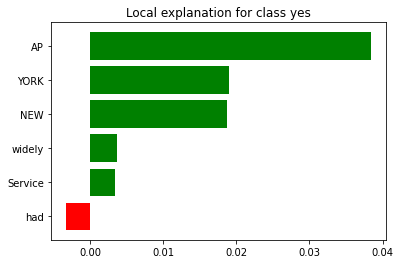

In [ ]:
%matplotlib inline
fig = exp.as_pyplot_figure()